Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Cargando datos

In [2]:
expuestos = pd.read_csv('https://raw.githubusercontent.com/JavierBurgos-web/Alll_Proyecto_Finanzas/main/2_data/BD_Expuestos.txt', sep='\t', encoding='latin-1')
sociodemograficos = pd.read_csv('https://raw.githubusercontent.com/JavierBurgos-web/Alll_Proyecto_Finanzas/main/2_data/BD_Sociodemograficas.txt', sep='\t', encoding='latin-1')
siniestros = pd.read_csv('https://media.githubusercontent.com/media/JavierBurgos-web/Alll_Proyecto_Finanzas/main/2_data/DB_Siniestros.txt', sep=',', encoding='latin-1')

##### **1. CONCATENACION DE BASES**

In [77]:
sociodemograficos = sociodemograficos.drop_duplicates(subset='Asegurado_Id', keep='first')

df = pd.merge(expuestos, sociodemograficos, on='Asegurado_Id', how='inner')
df = pd.merge(df, siniestros, on='Asegurado_Id', how='inner')
#display(df)

#### **2. TRANSFORMACIONES**

##### **2.1. Inputación y eliminación de información**

In [78]:
# Eliminación
## Elimina variable 'Poliza_Asegurado_Id' y 'Mes_Pago' no aporta.
df.drop(['Poliza_Asegurado_Id', 'Mes_Pago'], inplace=True, axis=1)
##Elimina registros asociados a la categoría 'Sin Información' de la variable 'Ciudad' y también respecto a los nulos
df = df[df['Ciudad'] != 'Sin Información']
df = df.dropna(subset=['Ciudad'])
## Elimina registros asociados al valor '-1' (registros nulos) de la variable 'Mujer' 
df = df[df['Mujer'] != -1]
## Elimina registros asociados al valor '-1' (registros nulos) de la variable 'Diagnostico_Codigo' 
df = df.loc[df['Diagnostico_Codigo'] != '-1']

# Imputación
df['FECHA_CANCELACION'] = df['FECHA_CANCELACION'].fillna(df['FECHA_FIN'])

##### **2.2. Reasignación de tipo y nombre de variables**

In [79]:
# Reasignar tipo a variables de fechas
df['FECHA_INICIO'] = pd.to_datetime(df['FECHA_INICIO'], format='%Y/%m/%d')
df['FECHA_CANCELACION'] = pd.to_datetime(df['FECHA_CANCELACION'], format='%Y/%m/%d')
df['FECHA_FIN'] = pd.to_datetime(df['FECHA_FIN'], format='%Y/%m/%d')
df['FechaNacimiento'] = pd.to_datetime(df['FechaNacimiento'], format='%d/%m/%Y')

# Renombrar
df = df.rename(columns={'Mujer': 'genero'})
df = df.rename(columns={'FechaNacimiento': 'fecha_nacimiento'})
df = df.rename(columns={'Poliza_Asegurado_Id': 'poliza_id'})

# Pasar la categoría '0' a ser categoría '9' dentro de la variable 'Diagnostico_Codigo'.
# las dos categorias representan la categoría 'Diagnostico pendiente'
df.Diagnostico_Codigo = df.Diagnostico_Codigo.replace({"0":"9"})

#Reasignar nombres bajo la nomenclatura Snake Case
df.columns = df.columns.str.lower().str.replace(' ', '_')

##### **2.2. Segmentación**

- [Anexo para la segmentación en función de la edad.](https://www.minsalud.gov.co/proteccionsocial/Paginas/cicloVida.aspx#:~:text=Persona%20Mayor%20(60%20a%C3%B1os%20o%20mas)%20envejecimiento%20y%20vejez)

- [Anexo para la segmentación de diagnosticos](https://mediately.co/es/icd)

In [80]:
print(f"La información de polizas corresponden al periodo comprendido entre {df['fecha_inicio'].min().year} y {df['fecha_fin'].max().year}, \n"
      f"por lo cual la edad de los usuarios se calculará hasta el año {df['fecha_fin'].max().year} \n")

La información de polizas corresponden al periodo comprendido entre 2018 y 2019, 
por lo cual la edad de los usuarios se calculará hasta el año 2019 



In [81]:
# SEGMENTACIÓN EN FUNCIÓN DE LA EDAD 

fecha_referencia = pd.Timestamp('2019-12-31')
df['edad'] = fecha_referencia.year - df['fecha_nacimiento'].dt.year

def segmentar_edad(edad):
    if edad <= 5:
        return 'Primera infancia'
    elif 6 <= edad <= 11:
        return 'Infancia'
    elif 12 <= edad <= 18:
        return 'Adolescencia'
    elif 19 <= edad <= 26:
        return 'Juventud'
    elif 27 <= edad <= 59:
        return 'Adultez'
    else:
        return 'Persona mayor'

df['segmento_edad'] = df['edad'].apply(segmentar_edad)
df = df.drop(["fecha_nacimiento","edad"],axis=1)


# SEGMENTACIÓN EN FUNCIÓN DE LA VARIABLE 'diagnostico_codigo'
# Esta megacategorización permite pasar de tner 5821 diagnosticos a tener 21 megacategorias.

def clasificar_diagnostico(df):
    df["letra_CIE"] = df["diagnostico_codigo"].str.slice(0, 2)
    
    clasificaciones = [
        (('A0', 'B9'), 'Enfermedades Infecciosas'),
        (('C0', 'D4'), 'Neoplasias'),
        (('D5', 'D8'), 'Enfermedades endocrinas'),
        (('F0', 'F9'), 'Trastornos mentales'),
        (('G0', 'G9'), 'Enfermedades del sistema nervioso'),
        (('H0', 'H5'), 'Enfermedades del ojo'),
        (('H6', 'H9'), 'Enfermedades del oído'),
        (('I0', 'I9'), 'Enfermedades del aparato circulatorio'),
        (('J0', 'J9'), 'Enfermedades respiratorias'),
        (('K0', 'K9'), 'Enfermedades digestivas'),
        (('L0', 'L9'), 'Enfermedades de la piel'),
        (('M0', 'M9'), 'Enfermedades del aparato musculoesqueletico'),
        (('N0', 'N9'), 'Enfermedades del aparato genitourinario'),
        (('O0', 'O9'), 'Embarazo, parto y puerperio'),
        (('P0', 'P9'), 'Afecciones en periodo perinatal'),
        (('Q0', 'Q9'), 'Malformaciones congenitas'),
        (('R0', 'R9'), 'Pruebas complementarias'),
        (('S0', 'T9'), 'Lesiones traumaticas'),
        (('V0', 'Y9'), 'Causas externas morbilidad'),
        (('Z0', 'Z9'), 'Factores que influyen en el estado de salud (Servicios Sanitarios)')
    ]
    
    for (start, end), clasificacion in clasificaciones:
        df.loc[(df['letra_CIE'] >= start) & (df['letra_CIE'] <= end), 'diagnostico'] = clasificacion
    
    # Convierte la columna a tipo 'object'
    df['diagnostico'] = df['diagnostico'].astype('object')

    # Asigna 'Diagnostico pendiente' a las filas donde 'diagnostico' es NaN equivalente a "9"
    df.loc[df['diagnostico'].isna(), 'diagnostico'] = 'Diagnostico pendiente'
    
    return df

df = clasificar_diagnostico(df)

# Elimina variables que contienen información que ya aborda la nueva variable
df.drop(['diagnostico_codigo', 'letra_CIE', 'diagnostico_desc'], inplace=True, axis=1)


# TIEMPO ACTIVO DE LA POLIZA EN MESES

## Calcula la diferencia en días entre las fechas
diferencia_dias = (df['fecha_cancelacion'] - df['fecha_inicio']).dt.days
## Convierte la diferencia en días a meses
df['tiempo_poliza'] = diferencia_dias / 30  # Asumiendo que un mes tiene 30 días aproximadamente
## Convierte el resultado a entero (meses)
df['tiempo_poliza'] = df['tiempo_poliza'].astype(int)

C:\Users\Javier Burgos\AppData\Local\Temp\ipykernel_9632\4159668096.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Enfermedades Infecciosas' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[(df['letra_CIE'] >= start) & (df['letra_CIE'] <= end), 'diagnostico'] = clasificacion


In [83]:
print(f"La base de datos contiene {df.shape[0]} observaciones y {df.shape[1]} variables, \n" 
      f"dentro de la cual se presentan {df.duplicated().sum()} registros duplicados, \n" 
      f"y {df.isnull().sum().sum()} observaciones vacías. \n")

display(df)

La base de datos contiene 3778956 observaciones y 17 variables, 
dentro de la cual se presentan 440020 registros duplicados, 
y 0 observaciones vacías. 



,asegurado_id,fecha_inicio,fecha_cancelacion,fecha_fin,genero,ciudad,cancer,epoc,diabetes,hipertension,enf_cardiovascular,reclamacion,eventos,valor_pagado,segmento_edad,diagnostico,tiempo_poliza
0,11885152,2018-01-01,2019-12-31,2019-12-31,0,Bogota,0,0,0,0,0,CONSULTA EXTERNA,1,4.395772e+05,Adultez,Diagnostico pendiente,24
1,763957,2018-01-01,2019-12-31,2019-12-31,0,Medellin,0,0,0,0,0,LABORATORIO CLINICO,1,4.231473e+05,Adultez,Diagnostico pendiente,24
2,763957,2018-01-01,2019-12-31,2019-12-31,0,Medellin,0,0,0,0,0,EXAMENES DE DIAGNOSTICO,1,4.581114e+05,Adultez,Diagnostico pendiente,24
3,763957,2018-01-01,2019-12-31,2019-12-31,0,Medellin,0,0,0,0,0,EXAMENES DE DIAGNOSTICO,1,4.074159e+05,Adultez,Factores que influyen en el estado de salud (S...,24
4,763957,2018-01-01,2019-12-31,2019-12-31,0,Medellin,0,0,0,0,0,FISIOTERAPIA ILIMITADA,5,4.990100e+05,Adultez,Diagnostico pendiente,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3779684,34905586,2018-01-01,2019-12-31,2019-12-31,0,Bogota,0,0,0,0,0,EXAMENES DE DIAGNOSTICO,2,9.311852e+05,Adultez,Diagnostico pendiente,24
3779685,34905586,2018-01-01,2019-12-31,2019-12-31,0,Bogota,0,0,0,0,0,CONSULTA DE URGENCIAS,1,7.523936e+05,Adultez,Diagnostico pendiente,24
3779686,34905586,2018-01-01,2019-12-31,2019-12-31,0,Bogota,0,0,0,0,0,EXAMENES DE DIAGNOSTICO,1,5.176030e+05,Adultez,Diagnostico pendiente,24
3779687,34905586,2018-01-01,2019-12-31,2019-12-31,0,Bogota,0,0,0,0,0,LABORATORIO CLINICO,1,8.801258e+05,Adultez,Diagnostico pendiente,24


#### **3. EXPLORACIÓN**

##### **3.1. Correlación**

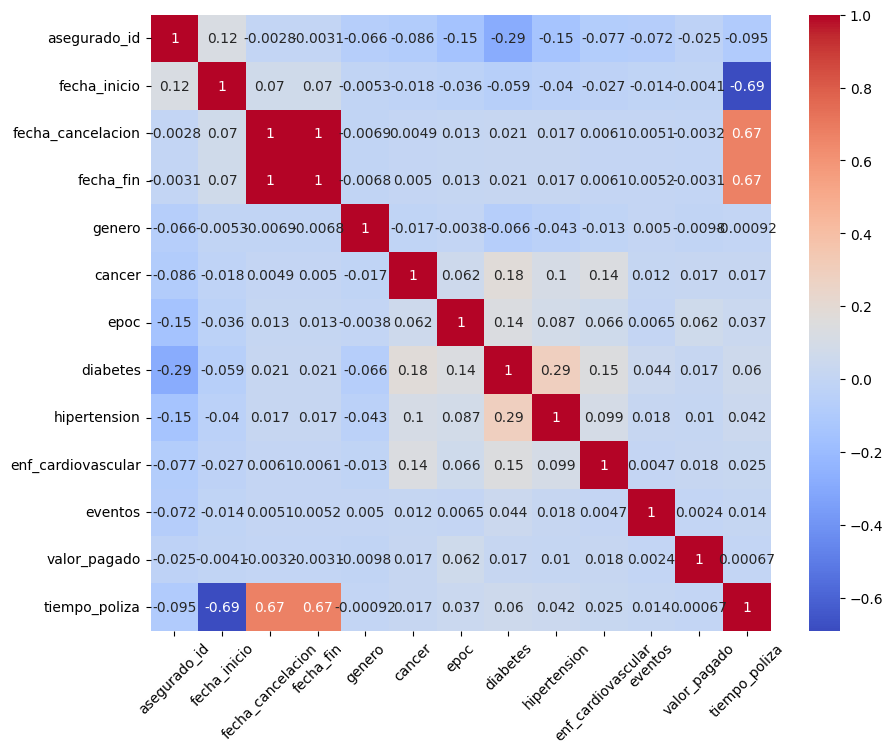

In [84]:
numeric_vars = df.select_dtypes(include=['number', 'datetime64[ns]', 'int64', 'float64'])

correlation_matrix = numeric_vars.corr()
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=ax)

ax.set_xticklabels(correlation_matrix.columns, rotation=45)
ax.set_yticklabels(correlation_matrix.columns, rotation=0)

plt.show()

In [85]:
df.drop(['fecha_inicio', 'fecha_fin', 'fecha_cancelacion'], inplace = True, axis = 1)

In [ ]:
import os
import pandas as pd

# Nombre del archivo
archivo = 'datos_preprocesados.csv'

# Verifica si el archivo existe y lo elimina si es así
if os.path.exists(archivo):
    os.remove(archivo)

# Supongamos que 'df' es tu DataFrame
# Exporta 'df' a un archivo CSV llamado 'archivo.csv'
df.to_csv(archivo, index=False)